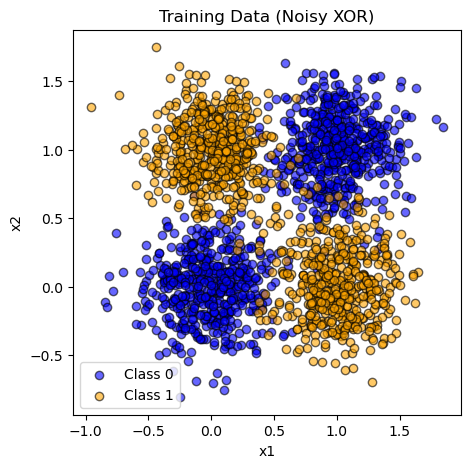

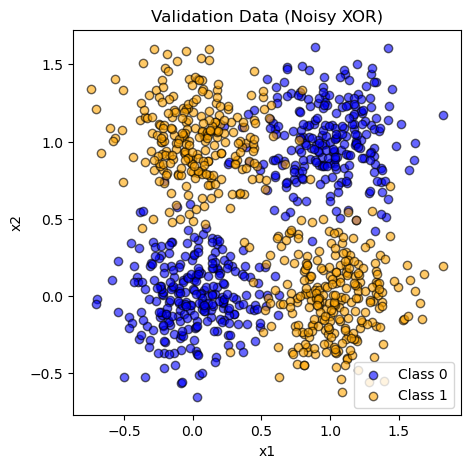

Training model...
Epoch 0: train_loss=0.6944, val_loss=0.6927
Epoch 20: train_loss=0.6880, val_loss=0.6874
Epoch 40: train_loss=0.6168, val_loss=0.6119
Epoch 60: train_loss=0.4503, val_loss=0.4493
Epoch 80: train_loss=0.3328, val_loss=0.3378
Epoch 100: train_loss=0.2642, val_loss=0.2727
Epoch 120: train_loss=0.2230, val_loss=0.2337
Epoch 140: train_loss=0.1972, val_loss=0.2092
Epoch 160: train_loss=0.1801, val_loss=0.1931
Epoch 180: train_loss=0.1686, val_loss=0.1819


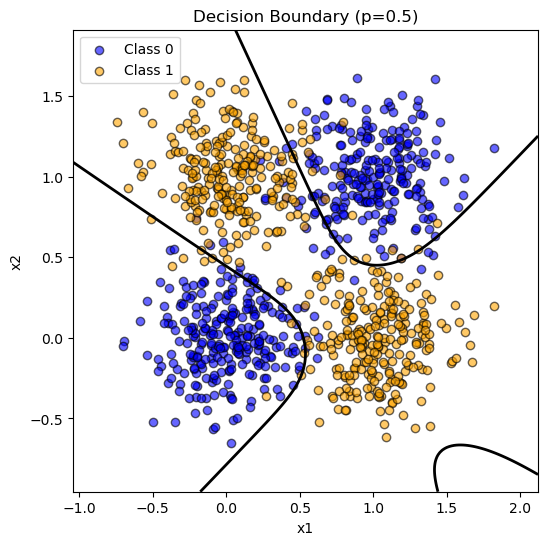

In [2]:
# feedforward_assignment.py
# --------------------------------------
# Fully commented PyTorch implementation of the noisy XOR experiment
# Contains:
#  - Data generation class
#  - Feedforward neural network class
#  - Training loop with DataLoader + Adam
#  - Visualization of data and learned decision boundary
# --------------------------------------

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. DATA GENERATION CLASS: Noisy XOR
# --------------------------------------------------
class NoisyXORDataset(Dataset):
    """
    Generates samples from the noisy XOR distribution.

    Each sample is created as:
       (x1, x2) = (m1 + s * η1,  m2 + s * η2)
       y        = XOR(m1, m2)

    where (m1, m2) is one of four possible centers:
       (0,0), (0,1), (1,0), (1,1)

    η1, η2 are standard normal noise.
    """

    def __init__(self, n_samples=1000, noise_std=0.25):
        super().__init__()
        self.n_samples = n_samples
        self.noise_std = noise_std

        # Define 4 center points
        self.centers = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
        # XOR labels for each center
        self.labels = np.array([0, 1, 1, 0], dtype=np.float32)

        # Generate all samples
        self.x, self.y = self._generate()

    def _generate(self):
        # Randomly choose one of the four centers for each sample
        idx = np.random.randint(0, 4, size=self.n_samples)
        base_points = self.centers[idx]

        # Add Gaussian noise
        noise = np.random.randn(self.n_samples, 2).astype(np.float32) * self.noise_std

        x = base_points + noise
        y = self.labels[idx]  # XOR result for chosen center

        return x, y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# --------------------------------------------------
# 2. FEEDFORWARD MODEL (example from assignment)
# --------------------------------------------------
class FeedForwardNet(nn.Module):
    """
    Neural network matching the example in the assignment:

        Linear(2 → 3)
        Tanh
        Linear(3 → 1)
        Identity (output)

    The output will be used with BCEWithLogitsLoss,
    so it is returned as raw logits.
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 3),   # input: 2 dims, hidden: 3 units
            nn.Tanh(),         # nonlinear activation
            nn.Linear(3, 1),   # output: 1 logit
            nn.Identity()      # required to match assignment printout
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# --------------------------------------------------
# 3. TRAINING LOOP
# --------------------------------------------------
def train(model, train_loader, val_loader, epochs=200, lr=1e-3):
    """
    Standard mini‑batch training using Adam optimizer.
    """
    loss_fn = nn.BCEWithLogitsLoss()  # applies sigmoid internally
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_history = []
    val_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xbatch, ybatch in train_loader:
            xbatch = xbatch.float()
            ybatch = ybatch.float()

            optimizer.zero_grad()
            logits = model(xbatch)
            loss = loss_fn(logits, ybatch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xbatch)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # Evaluate on validation set
        val_loss = evaluate(model, val_loader, loss_fn)

        train_history.append(avg_train_loss)
        val_history.append(val_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={val_loss:.4f}")

    return train_history, val_history

# --------------------------------------------------
# 4. EVALUATION
# --------------------------------------------------
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xbatch, ybatch in loader:
            xbatch = xbatch.float()
            ybatch = ybatch.float()
            logits = model(xbatch)
            loss = loss_fn(logits, ybatch)
            total_loss += loss.item() * len(xbatch)
    return total_loss / len(loader.dataset)

# --------------------------------------------------
# 5. VISUALIZATION
# --------------------------------------------------
def plot_points(dataset, title):
    """
    Scatter plot of noisy XOR data (blue = class 0, orange = class 1).
    """
    x, y = dataset.x, dataset.y

    plt.figure(figsize=(5,5))
    plt.scatter(x[y==0,0], x[y==0,1], label="Class 0", c="blue", edgecolor="k", alpha=0.6)
    plt.scatter(x[y==1,0], x[y==1,1], label="Class 1", c="orange", edgecolor="k", alpha=0.6)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_decision_boundary(model, dataset, grid_res=200):
    """
    Draw the 50% probability contour (decision boundary) predicted by the model.
    """
    x, y = dataset.x, dataset.y

    # Create a grid of (x1, x2) points
    x_min, x_max = x[:,0].min() - 0.3, x[:,0].max() + 0.3
    y_min, y_max = x[:,1].min() - 0.3, x[:,1].max() + 0.3

    xx = np.linspace(x_min, x_max, grid_res)
    yy = np.linspace(y_min, y_max, grid_res)
    X1, X2 = np.meshgrid(xx, yy)
    grid = np.stack([X1.ravel(), X2.ravel()], axis=1).astype(np.float32)

    # Model predictions
    with torch.no_grad():
        logits = model(torch.from_numpy(grid))
        probs = torch.sigmoid(logits).numpy().reshape(X1.shape)

    # Plot contour where probability = 0.5
    plt.figure(figsize=(6,6))
    plt.contour(X1, X2, probs, levels=[0.5], linewidths=2, colors="k")

    # Plot data
    plt.scatter(x[y==0,0], x[y==0,1], c="blue", label="Class 0", edgecolor="k", alpha=0.6)
    plt.scatter(x[y==1,0], x[y==1,1], c="orange", label="Class 1", edgecolor="k", alpha=0.6)

    plt.title("Decision Boundary (p=0.5)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

# --------------------------------------------------
# 6. MAIN EXECUTION EXAMPLE
# --------------------------------------------------
if __name__ == "__main__":
    # Create training and validation datasets
    train_data = NoisyXORDataset(n_samples=2000, noise_std=0.25)
    val_data   = NoisyXORDataset(n_samples=1000, noise_std=0.25)

    # Visualize noisy XOR data
    plot_points(train_data, "Training Data (Noisy XOR)")
    plot_points(val_data, "Validation Data (Noisy XOR)")

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=64)

    # Initialize model
    model = FeedForwardNet()

    # Train
    print("Training model...")
    train_hist, val_hist = train(model, train_loader, val_loader, epochs=200, lr=1e-3)

    # Plot decision boundary
    plot_decision_boundary(model, val_data)
